In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [211]:
# Load processed dataset
X_train = pd.read_csv('./X_train.csv')
X_test = pd.read_csv('./X_test.csv')
y_train = pd.read_csv('./y_train.csv')['SalePrice']

In [212]:
# Remove highly correlated features
cmatrix = X_train.corr()

upper_tri = cmatrix.where(np.triu(np.ones(cmatrix.shape),k=1).astype('bool'))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= .95)]

X_train.drop(columns=to_drop,inplace=True)
X_test.drop(columns=to_drop,inplace=True)

In [213]:
# Split data into sets for model training, model validation, and stack training
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)
stackX_train, X_val, stacky_train, y_val = train_test_split(X_val, y_val, test_size=0.5, shuffle=True)

mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_val = mms.transform(X_val)
stackX_train = mms.transform(stackX_train)
X_test = mms.transform(X_test)

C:\Users\lewis\AppData\Local\Temp\ipykernel_13812\2621687044.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=baseline_model,


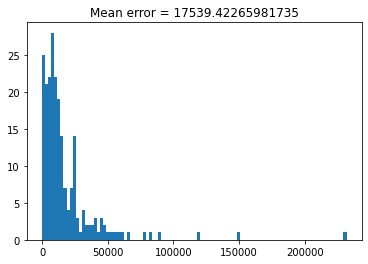

In [214]:
# Benchmark model
K.clear_session()
in_dim = np.shape(X_train)[1]


def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=in_dim, activation='tanh'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model



model = KerasRegressor(build_fn=baseline_model,
                       epochs=1000,
                       batch_size=64,
                       verbose=0,
                       validation_data=(X_val, y_val),
                       callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                    patience=10,
                                                                    min_delta=1e-6,
                                                                    restore_best_weights=True))



model.fit(X_train, y_train)
yp_ann = model.predict(X_val)
err = np.abs(yp_ann-y_val)

plt.hist(err,bins=100)

plt.title(f'Mean error = {np.mean(err)}')
plt.show()

In [ ]:
# Train various models to estimate their performance
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, PoissonRegressor, LassoCV, ElasticNetCV, RidgeCV
from sklearn.svm import LinearSVR
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ann_model = KerasRegressor(build_fn=baseline_model,
                       epochs=1000,
                       batch_size=64,
                       verbose=0,
                       validation_data=(X_val, y_val),
                       callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                    patience=10,
                                                                    min_delta=1e-6,
                                                                    restore_best_weights=True))

models = [ann_model,
          XGBRegressor(eval_metric='mae',n_estimators=500,max_depth=5, early_stopping_rounds=10),
          GradientBoostingRegressor(n_iter_no_change=10),
          AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),n_estimators=500),
          CatBoostRegressor(early_stopping_rounds=5,verbose=0),
          LassoCV(),
          ElasticNetCV(),
          RidgeCV(),
          PoissonRegressor(max_iter=100000)]

titles = ['ANN',
          'XGBoost',
          'GBR',
          'Ada',
          'CatBoost',
          'Lasso',
          'ElasticNet',
          'Ridge',
          'Poisson']

yp = []
err = []
ct = 0
for model in models:
    print(f'Training {titles[ct]}')
    
    if titles[ct] == 'XGBoost':
        model.fit(X_train,y_train, eval_set=[(X_val,y_val)], verbose=0)
        yp_ = model.predict(X_val)
        
    else:
        model.fit(X_train,y_train)
        yp_ = model.predict(X_val)
        
    
        
    
    yp.append(yp_.reshape(-1,1))
    err.append(np.abs(yp_-y_val))
    ct+=1

    
predictions = yp[0]
for i in range(1,len(yp)):
    predictions = np.concatenate((predictions,yp[i]),axis=1)


fix,ax = plt.subplots(nrows=3,ncols=4,figsize=(15,6))
ax = ax.flatten()

for i in range(len(yp)):
    ax[i].hist(err[i],bins=100)
    ax[i].set_title(f'{titles[i]}: Mean error = {np.round(np.mean(err[i]),1)}')


plt.tight_layout()

C:\Users\lewis\AppData\Local\Temp\ipykernel_13812\1664630802.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann_model = KerasRegressor(build_fn=baseline_model,


Training ANN


In [209]:
# Stack the best models into a single meta-model using linear regression as the meta-estimator algorithm
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

def stack_predict(stack_, X):
    preds = np.zeros((X.shape[0],len(stack_)))

    for i in range(len(model_stack)):
        preds[:,i] = stack_[i].predict(X)
    
    return preds


model_stack = [models[0],
               models[1],
               models[2],
               models[3],
               models[4],
               models[5],
               models[7],
               models[8]]

stack = LinearRegression()

stack.fit(stack_predict(model_stack, stackX_train),
          stacky_train)

yp_stack = stack.predict(stack_predict(model_stack, X_val))
err_stack = np.abs(yp_stack-y_val)
print(f'Mean error with stacking: {np.mean(err_stack)}')

test_pred = stack.predict(stack_predict(model_stack, X_test))

Mean error with stacking: 14832.047645031495


In [210]:
# Save predictions for submission
pred = pd.DataFrame(test_pred)
sub_df = pd.read_csv('sample_submission.csv')
datasets = pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns = ['Id', 'SalePrice']
datasets.to_csv('submission_1.csv',index=False)